# Regression of circular dependent variable on linear regressor

In this notebook, we demonstrate an adaptation of ordinary linear regression in which the dependent variable is circular (e.g. an angle or a direction). Such a case arises, for example, in the analysis of the relation between hippocampal place cell activity and the theta population rhythm. Upon entry of their place field, place cells fire action potentials during the late phase of the local theta rhythm. Towards the exit of the place field, the place cells will fire action potentials earlier in the theta cycle. Thus, place cell firing shows *phase precession* relative to the theta rhythm. This position-phase relationship can be described by a linear model: $$\theta(x)=[intercept + slope \cdot x] \mod 2 \pi$$ where *intercept* and *slope* are the unknown parameters that we would like to estimate from the data.

As in ordinary least squares, we can define an objective or loss function that expresses the squared error between the actual $\theta$ and the modeled $\hat{\theta}$ for a given combination of intercept and slope: $$\frac{1}{N}\sum_{i=0}^{N}{\Delta(\hat{\theta}_i,\theta_i)^2}$$ where $\Delta(a,b)$ represents the circular difference between two angles. The goal the regression is tofind the values for intercept and slope that minimize this error. The objective function has many local minima, and thus in the implementation of the *linear_circular_regression* function a global minimization approach is used (more specifically: differential evolution).

## Define linear-circular regression function

## Test linear-circular regression

In [ ]:
import numpy as np
import fklab.statistics.circular as circ

import matplotlib.pyplot as plt

%matplotlib inline

### Create data set

In [ ]:
# variables
n = 1000  # number of samples
kappa = 1  # spread of noise (values closer to zero result in more noise)
offset = 1.5 * np.pi
slope = -np.pi / 2.5
xmin, xmax = 10, 20  # range of x values

x, theta = circ.generate_linear_circular_dataset(
    nsamples=n, xmin=xmin, xmax=xmax, intercept=offset, slope=slope, noise=kappa
)

# test if function handles NaNs properly
# x[0] = np.nan

### Plot data

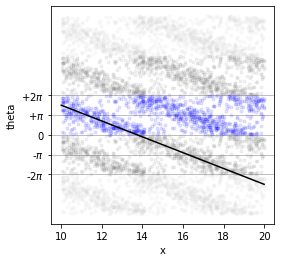

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot(x, theta, ".", color="b", alpha=0.1)
ax.plot(x, theta + 2 * np.pi, ".", color="gray", alpha=0.1)
ax.plot(x, theta - 2 * np.pi, ".", color="gray", alpha=0.1)
ax.plot(x, theta + 4 * np.pi, ".", color="lightgray", alpha=0.1)
ax.plot(x, theta - 4 * np.pi, ".", color="lightgray", alpha=0.1)

# find intercept in [0,2*pi] at xmin
icept = circ.wrap(offset + xmin * slope, low=0, high=2 * np.pi)
ax.plot([xmin, xmax], icept + slope * np.array([0, xmax - xmin]), "k")

ax.set(
    yticks=np.linspace(-2, 2, 5) * np.pi,
    yticklabels=["-2$\pi$", "-$\pi$", "0", "+$\pi$", "+2$\pi$"],
    xlabel="x",
    ylabel="theta",
)

ax.grid(axis="y");

### Hyperparameter tuning (optional)

In [ ]:
import scipy.optimize
import sklearn.model_selection

In [ ]:
kfold = sklearn.model_selection.KFold(n_splits=5)


def cvfcn(coef):
    model = circ.CircularLinearRegression(min_period=coef[0], regularization=coef[1])
    return -np.mean(
        sklearn.model_selection.cross_val_score(model, x[:, None], theta, cv=kfold)
    )


result = scipy.optimize.differential_evolution(
    cvfcn, [(0.1, 100), (0, 10)], strategy="best1bin"
)

optim_min_period = result.x[0]
optim_regularization = result.x[1]
print(
    "min_period: {}, regularization: {}".format(optim_min_period, optim_regularization)
)

min_period: 1.2291434465883597, regularization: 0.00299590811201611


In [ ]:
old_model = circ.CircularLinearRegression(min_period=None, regularization=0.0)
new_model = circ.CircularLinearRegression(
    min_period=optim_min_period, regularization=optim_regularization
)

old_model.fit(x[:, None], theta)
new_model.fit(x[:, None], theta)

results = sklearn.model_selection.cross_val_score(
    old_model, x[:, None], theta, cv=kfold
)
print("old model mean score: {:.3f}".format(np.mean(results)))

results = sklearn.model_selection.cross_val_score(
    new_model, x[:, None], theta, cv=kfold
)
print("new model mean score: {:.3f}".format(np.mean(results)))

old model mean score: 0.492
new model mean score: 0.492


### Perform regression

In [ ]:
# perform regression and compute confidence intervals
(offset, slope), r, fcn, res, (ci_offset, ci_slope) = circ.linear_circular_regression(
    x,
    theta,
    min_period=optim_min_period,
    ci="theory",
    regularization=optim_regularization,
)

In [ ]:
print("offset = {:.2f}, slope = {:.2f}, r={:.2f}".format(offset, slope, r))

offset = 4.58, slope = -1.25, r=0.50


offset: 4.16 - (4.58) - 4.99
slope : -1.28 - (-1.25) - -1.22
period: -4.91 - (-5.02) - -5.13


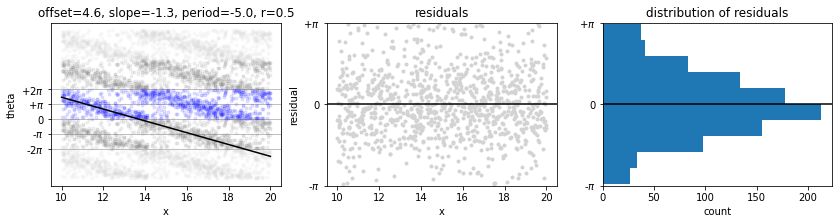

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(14, 3))

ax[0].plot(x, theta, ".", color="b", alpha=0.1)
ax[0].plot(x, theta + 2 * np.pi, ".", color="gray", alpha=0.1)
ax[0].plot(x, theta - 2 * np.pi, ".", color="gray", alpha=0.1)
ax[0].plot(x, theta + 4 * np.pi, ".", color="lightgray", alpha=0.1)
ax[0].plot(x, theta - 4 * np.pi, ".", color="lightgray", alpha=0.1)

# find intercept in [0,2*pi] at xmin
icept = circ.wrap(offset + xmin * slope, low=0, high=2 * np.pi)
ax[0].plot([xmin, xmax], icept + slope * np.array([0, xmax - xmin]), "k")

ax[0].set(
    yticks=np.linspace(-2, 2, 5) * np.pi,
    yticklabels=["-2$\pi$", "-$\pi$", "0", "+$\pi$", "+2$\pi$"],
    xlabel="x",
    ylabel="theta",
    title="offset={:.1f}, slope={:.1f}, period={:.1f}, r={:.1f}".format(
        offset, slope, 2 * np.pi / slope, r
    ),
)

ax[0].grid(axis="y")

ax[1].plot(x, res, ".", color="lightgray")
ax[1].set(
    xlabel="x",
    ylabel="residual",
    ylim=(-np.pi, np.pi),
    title="residuals",
    yticks=[-np.pi, 0, np.pi],
    yticklabels=["-$\pi$", 0, "+$\pi$"],
)
ax[1].axhline(0, color="k")

ax[2].hist(res, orientation="horizontal")
ax[2].set(
    ylim=(-np.pi, np.pi),
    title="distribution of residuals",
    yticks=[-np.pi, 0, np.pi],
    xlabel="count",
    yticklabels=["-$\pi$", 0, "+$\pi$"],
)
ax[2].axhline(0, color="k")

print("offset: {:.2f} - ({:.2f}) - {:.2f}".format(ci_offset[0], offset, ci_offset[1]))
print("slope : {:.2f} - ({:.2f}) - {:.2f}".format(ci_slope[0], slope, ci_slope[1]))
print(
    "period: {:.2f} - ({:.2f}) - {:.2f}".format(
        2 * np.pi / ci_slope[0], 2 * np.pi / slope, 2 * np.pi / ci_slope[1]
    )
)

## Manual bootstrapping (for testing purposes)

In [ ]:
slopes = []
for a in range(200):
    index = np.random.choice(len(x), len(x))
    (offset, slope), r, fcn, res, ci = circ.linear_circular_regression(
        x[index],
        theta[index],
        min_period=optim_min_period,
        ci="none",
        regularization=optim_regularization,
    )
    slopes.append(slope)

[-1.29073775 -1.20822286]


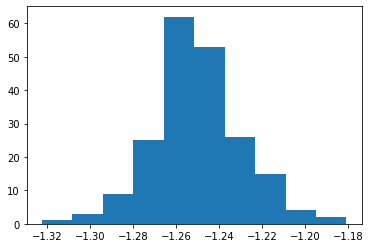

In [ ]:
plt.hist(slopes)
print(np.nanpercentile(slopes, [2.5, 97.5]))

## Plot objective function with and without regularization (Advanced)

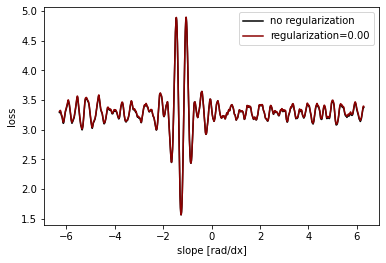

In [ ]:
from fklab.statistics.circular.linear_circular_regression import obj_fcn

fcn = lambda slope, regularization=0.0: obj_fcn(
    np.array([offset, slope]), x, theta, regularization
)

fig, ax = plt.subplots(1)
xval = np.linspace(-2 * np.pi, 2 * np.pi, 2000)
ax.plot(xval, [fcn(z) for z in xval], "k", label="no regularization")
ax.plot(
    xval,
    [fcn(z, optim_regularization) for z in xval],
    "darkred",
    label="regularization={:.2f}".format(optim_regularization),
)
ax.set(xlabel="slope [rad/dx]", ylabel="loss")
ax.legend();